# Setting up the Environment

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Activation, Dense, BatchNormalization, MaxPooling2D, Flatten

In [2]:
tf.__version__

'2.0.0-beta1'

In [3]:
tf.test.is_gpu_available()

True

# Getting the Data

In [4]:
data = pd.read_csv("train.csv")
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data.shape

(42000, 785)

In [6]:
X = data.iloc[:,1:]
y = data[['label']]

# Splitting the Data into Train and Validation

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0, shuffle = True)

In [8]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (33600, 784)
y_train :  (33600, 1)
X_valid :  (8400, 784)
y_valid :  (8400, 1)


# Reshaping the Train and Validation Data

**The Images have 784 pixels, that is, 28x28 pixels and 1 channel(greyscale).**

In [9]:
X_train = X_train.to_numpy().reshape(-1, 28, 28, 1)  
y_train = y_train.to_numpy()

In [10]:
X_valid = X_valid.to_numpy().reshape(-1, 28, 28, 1)
y_valid = y_valid.to_numpy()

In [11]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_valid : ", X_valid.shape)
print("y_valid : ", y_valid.shape)

X_train :  (33600, 28, 28, 1)
y_train :  (33600, 1)
X_valid :  (8400, 28, 28, 1)
y_valid :  (8400, 1)


In [12]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [13]:
np.unique(y_valid)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

# Displaying 10 random examples

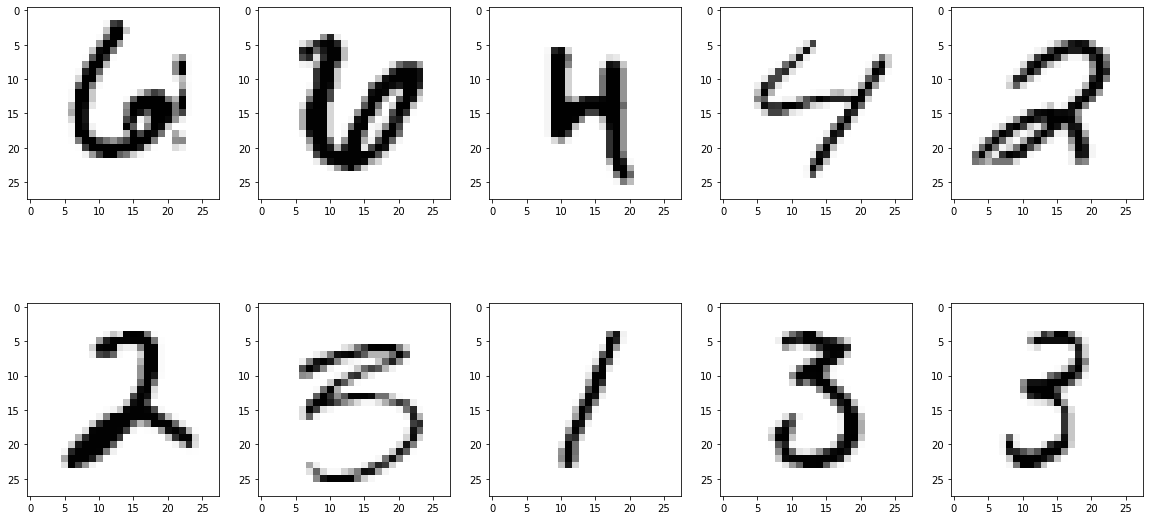

In [14]:
fig = plt.figure(figsize = (20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap = 'Greys')    
plt.show()

# Creating the Convolutional Neural Network

In [15]:
model = Sequential()

model.add(Conv2D(16, kernel_size = 3, padding = 'same', input_shape = (28, 28, 1)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
          
model.add(Conv2D(64, kernel_size = 3, padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))

model.add(Conv2D(128, kernel_size = 3, padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(256, kernel_size = 3, padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, kernel_size = 3, padding = 'same'))
#model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2)))
          
model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.5))

model.add(Dense(10, activation = 'softmax'))

**I experimented with BatchNormalization and Dropout, but they seemed to reduce both the Training and Validation accuracy. So, I removed them.**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        9280      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 128)       0

# Creating the Train and Test Image Generators

In [17]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.2,
                                   zoom_range = 0.15,
                                   rescale = (1./255)) 

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
train_generator = train_datagen.flow(X_train, y_train, batch_size = 2048, shuffle = True)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size = 16, shuffle = True)

# Compiling and Fitting the Model

In [19]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [20]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = len(train_generator),
                           epochs = 250,
                           validation_data = validation_generator,
                           verbose = 2,
                           validation_steps = len(validation_generator),
                           validation_freq = 1)

Epoch 1/250


W0825 20:42:15.061905  9928 deprecation.py:323] From C:\Users\RAJDEEP\Anaconda\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


17/17 - 12s - loss: 2.0553 - accuracy: 0.2653 - val_loss: 2.1304 - val_accuracy: 0.4092
Epoch 2/250
17/17 - 9s - loss: 1.4552 - accuracy: 0.5383 - val_loss: 0.6216 - val_accuracy: 0.8050
Epoch 3/250
17/17 - 9s - loss: 0.7417 - accuracy: 0.7648 - val_loss: 0.3439 - val_accuracy: 0.9018
Epoch 4/250
17/17 - 9s - loss: 0.4785 - accuracy: 0.8552 - val_loss: 0.2067 - val_accuracy: 0.9433
Epoch 5/250
17/17 - 9s - loss: 0.3645 - accuracy: 0.8851 - val_loss: 0.1733 - val_accuracy: 0.9499
Epoch 6/250
17/17 - 9s - loss: 0.3060 - accuracy: 0.9064 - val_loss: 0.1516 - val_accuracy: 0.9567
Epoch 7/250
17/17 - 9s - loss: 0.2577 - accuracy: 0.9199 - val_loss: 0.1139 - val_accuracy: 0.9671
Epoch 8/250
17/17 - 9s - loss: 0.2202 - accuracy: 0.9315 - val_loss: 0.0958 - val_accuracy: 0.9729
Epoch 9/250
17/17 - 9s - loss: 0.2223 - accuracy: 0.9309 - val_loss: 0.1013 - val_accuracy: 0.9696
Epoch 10/250
17/17 - 9s - loss: 0.2100 - accuracy: 0.9349 - val_loss: 0.0861 - val_accuracy: 0.9739
Epoch 11/250
17/17 -

17/17 - 9s - loss: 0.0420 - accuracy: 0.9864 - val_loss: 0.0179 - val_accuracy: 0.9957
Epoch 84/250
17/17 - 9s - loss: 0.0368 - accuracy: 0.9880 - val_loss: 0.0210 - val_accuracy: 0.9944
Epoch 85/250
17/17 - 9s - loss: 0.0383 - accuracy: 0.9884 - val_loss: 0.0193 - val_accuracy: 0.9943
Epoch 86/250
17/17 - 9s - loss: 0.0363 - accuracy: 0.9881 - val_loss: 0.0200 - val_accuracy: 0.9938
Epoch 87/250
17/17 - 9s - loss: 0.0364 - accuracy: 0.9887 - val_loss: 0.0184 - val_accuracy: 0.9942
Epoch 88/250
17/17 - 9s - loss: 0.0389 - accuracy: 0.9879 - val_loss: 0.0249 - val_accuracy: 0.9924
Epoch 89/250
17/17 - 9s - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0242 - val_accuracy: 0.9919
Epoch 90/250
17/17 - 9s - loss: 0.0390 - accuracy: 0.9880 - val_loss: 0.0209 - val_accuracy: 0.9932
Epoch 91/250
17/17 - 9s - loss: 0.0360 - accuracy: 0.9884 - val_loss: 0.0197 - val_accuracy: 0.9946
Epoch 92/250
17/17 - 9s - loss: 0.0359 - accuracy: 0.9884 - val_loss: 0.0213 - val_accuracy: 0.9939
Epoch 93/250


Epoch 165/250
17/17 - 9s - loss: 0.0242 - accuracy: 0.9918 - val_loss: 0.0197 - val_accuracy: 0.9942
Epoch 166/250
17/17 - 9s - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0207 - val_accuracy: 0.9939
Epoch 167/250
17/17 - 9s - loss: 0.0260 - accuracy: 0.9909 - val_loss: 0.0251 - val_accuracy: 0.9933
Epoch 168/250
17/17 - 9s - loss: 0.0224 - accuracy: 0.9930 - val_loss: 0.0180 - val_accuracy: 0.9951
Epoch 169/250
17/17 - 9s - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0161 - val_accuracy: 0.9961
Epoch 170/250
17/17 - 9s - loss: 0.0237 - accuracy: 0.9927 - val_loss: 0.0191 - val_accuracy: 0.9948
Epoch 171/250
17/17 - 9s - loss: 0.0233 - accuracy: 0.9928 - val_loss: 0.0173 - val_accuracy: 0.9956
Epoch 172/250
17/17 - 9s - loss: 0.0243 - accuracy: 0.9924 - val_loss: 0.0208 - val_accuracy: 0.9943
Epoch 173/250
17/17 - 9s - loss: 0.0265 - accuracy: 0.9918 - val_loss: 0.0220 - val_accuracy: 0.9943
Epoch 174/250
17/17 - 9s - loss: 0.0213 - accuracy: 0.9927 - val_loss: 0.0234 - val_accurac

17/17 - 9s - loss: 0.0192 - accuracy: 0.9938 - val_loss: 0.0173 - val_accuracy: 0.9948
Epoch 247/250
17/17 - 9s - loss: 0.0179 - accuracy: 0.9945 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 248/250
17/17 - 9s - loss: 0.0166 - accuracy: 0.9948 - val_loss: 0.0191 - val_accuracy: 0.9952
Epoch 249/250
17/17 - 9s - loss: 0.0151 - accuracy: 0.9954 - val_loss: 0.0216 - val_accuracy: 0.9949
Epoch 250/250
17/17 - 9s - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.0184 - val_accuracy: 0.9954


# Plotting the Losses

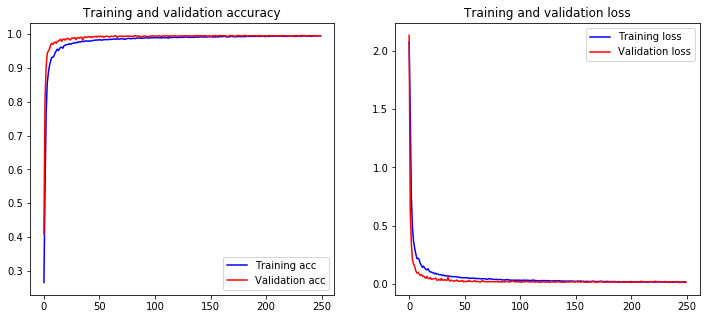

In [21]:
def plot_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


plot_loss(hist)

# Saving the Model

In [22]:
model.save('model_Keras.h5')

# Evaluating the Model

In [23]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps = len(train_generator))
print("Train Loss: ", train_loss)
print("Train Acc: ", train_acc)

Train Loss:  0.016600476358743274
Train Acc:  0.9947917


In [24]:
validation_loss, validation_acc = model.evaluate_generator(validation_generator, steps = len(validation_generator))
print("Validation Loss: ", validation_loss)
print("Validation Acc: ", validation_acc)

Validation Loss:  0.01838196912108829
Validation Acc:  0.99535716


# Getting the Test Data

In [25]:
test_data = pd.read_csv("test.csv")
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Reshaping the Test Data

In [26]:
X_test = test_data.to_numpy().reshape(-1, 28, 28, 1)
print(X_test.shape)

(28000, 28, 28, 1)


# Rescaling the Test Input

In [27]:
X_test = X_test / 255

# Predicting the Labels of the Test Data

In [28]:
pred_probs = model.predict(X_test, batch_size = 2048)
print(pred_probs.shape)

(28000, 10)


In [29]:
pred_labels = pred_probs.argmax(axis=1)
pred_labels.shape

(28000,)

# Creating the Output CSV File

In [30]:
imageid = np.arange(pred_labels.shape[0]) + 1
imageid

array([    1,     2,     3, ..., 27998, 27999, 28000])

In [31]:
df = pd.DataFrame({'ImageId': imageid, 'Label': pred_labels})
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [32]:
df.to_csv('output_Keras.csv', index = False)

**This model gave a score of 0.99442 (~99.44% accuracy) when the output was submitted to Kaggle**